In [1]:
import re
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

In [2]:
csv = pd.read_table('FIFIndex_BPL_players.csv', sep=',', index_col = 0)
csv.head(10)

,Name,UpdateDate,Country,OverallScore,PotentialScore,Height,Weight,PreferredFoot,BirthDate,Age,...,LongShots,Curve,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes
0,Mesut Özil,Dec_12_2016,Germany,89,89,183 cm,76 kg,Left,10/15/1988,28,...,76,84,79,67,77,6,6,14,10,14
1,Harry Kane,Dec_12_2016,England,84,90,188 cm,86 kg,Right,07/28/1993,23,...,78,71,66,82,70,14,8,10,11,11
2,Coutinho,Dec_12_2016,Brazil,85,90,171 cm,68 kg,Right,06/12/1992,24,...,85,84,79,64,75,14,12,7,9,6
3,Sergio Agüero,Dec_12_2016,Argentina,89,89,172 cm,74 kg,Right,06/02/1988,28,...,84,82,72,80,85,11,13,15,6,14
4,Nemanja Matić,Dec_12_2016,Serbia,84,84,194 cm,84 kg,Left,08/01/1988,28,...,75,68,67,69,74,14,7,15,12,9
5,Vincent Kompany,Dec_12_2016,Belgium,85,85,192 cm,85 kg,Right,04/10/1986,30,...,55,61,52,63,46,8,10,9,5,6
6,Cesc Fàbregas,Dec_12_2016,Spain,86,86,175 cm,74 kg,Right,05/04/1987,29,...,75,77,81,80,81,15,6,10,8,15
7,Riyad Mahrez,Dec_12_2016,Algeria,84,87,179 cm,62 kg,Left,02/21/1991,25,...,74,78,72,72,71,11,15,9,13,6
8,Granit Xhaka,Dec_12_2016,Switzerland,84,87,185 cm,82 kg,Left,09/27/1992,24,...,85,68,70,59,50,7,7,8,11,13
9,Claudio Bravo,Dec_12_2016,Chile,85,85,184 cm,80 kg,Right,04/13/1983,33,...,21,25,60,23,11,78,83,85,87,85


In [3]:
name = csv.Name.tolist()
birth = csv.BirthDate.tolist()
#update = csv.UpdateDate.tolist()
playerid = []

for ind in range(len(name)):
    playerid.append(name[ind] + ' ' + birth[ind])

csv.insert(loc=0, column='PlayerID', value=playerid) #Append name ,birthdate and update date as playerID in the csv

In [4]:
overS = csv.OverallScore.tolist()
potenS = csv.PotentialScore.tolist()

growth = []

for ind in range(len(overS)):
    growth.append(round(abs(overS[ind] - potenS[ind]) / overS[ind] * 100))

csv.insert(loc=6, column='PotentialGrowth(%)', value=growth) #Append the potentional growth in the csv

In [5]:
workRate = csv.PlayerWorkRate.tolist()
attWorkRate = []
defWorkRate = []

for item in workRate:
    lis = item.split(' / ')
    attWorkRate.append(lis[0])
    defWorkRate.append(lis[1])

csv.insert(loc=12, column='AttWorkRate', value=attWorkRate)
csv.insert(loc=13, column='DefWorkRate', value=defWorkRate) #Seperate the attack workrate and defense workrate
csv.drop('PlayerWorkRate', axis=1, inplace=True)

In [6]:
prePositions = csv.PreferredPositions.tolist()
counts = []
for item in prePositions:
    if '/' not in item:
        count = 1
    else:
        count = len(item.split('/'))
    
    counts.append(count)
    
csv.insert(loc=15, column='NumberOfPositisions', value=counts) #Add number of positions to the csv

In [7]:
startYear = csv.Year.tolist()
endYear = csv.Contract.tolist()

years = []
for ind in range(len(startYear)):
    year = int(endYear[ind]) - int(startYear[ind].split('/')[2])   
    years.append(year)
    
csv.insert(loc=20, column='YearsLeftInContract', value=years) #Add years left in contract to the csv

In [8]:
nation = csv.Country.tolist()

homeTown = []
for item in nation:
    if item == 'England':
        homeTown.append(1)
    else:
        homeTown.append(0)
    
csv.insert(loc=4, column='IsHomeGrown', value=homeTown) #Add hownTown in contract to the csv

In [9]:
csv['Height'] = csv['Height'].apply(lambda x: int(re.findall('\d+', x)[0]))
csv['Weight'] = csv['Weight'].apply(lambda x: int(re.findall('\d+', x)[0]))

height = csv.Height.tolist()
weight = csv.Weight.tolist()

minus = []
plus = []

for ind in range(len(height)):
    minus.append(abs(height[ind] - weight[ind])) #Use height minus weight to find those people who are tall but thin or short but strong
    plus.append(height[ind] + weight[ind]) #Use height plus weight to find those people who are tall and strong or short and thin

sort_minus = sorted(minus)
sort_plus = sorted(plus)

last10m = sort_minus[int(len(minus) * (1/10))] #Find the 10% overall treshholds for outliers
top10m = sort_minus[-int(len(minus) * (1/10))]

last10p = sort_plus[int(len(minus) * (1/10))]
top10p = sort_plus[-int(len(minus) * (1/10))]

resultPhy = []

for item in minus:
    if (item >= top10m) or (item <= last10m):
        resultPhy.append(1)
    else:
        resultPhy.append(0)
        
for ind in range(len(plus)):
    if (plus[ind] >= top10p) or (plus[ind] <= last10p):
        if resultPhy[ind] == 0:
            resultPhy[ind] = 1

csv.insert(loc=10, column='IsPhysicalAnomaly', value=resultPhy) #Add IsPhysicalAnomaly in contract to the csv
csv[['Height', 'Weight', 'IsPhysicalAnomaly']].head(10)

,Height,Weight,IsPhysicalAnomaly
0,183,76,0
1,188,86,0
2,171,68,1
3,172,74,1
4,194,84,1
5,192,85,1
6,175,74,0
7,179,62,1
8,185,82,0
9,184,80,0


In [10]:
ids = csv['PlayerID'].tolist()
teamDic = {}

for item in set(ids):
    teams = set(csv.loc[csv['PlayerID'] == item, 'Team'].tolist())
    teamDic[item] = teams

switch = []

for item in ids:
    if len(teamDic[item]) == 1:
        switch.append(0)
    else:
        switch.append(1)

csv.insert(loc=20, column='SwitchedTeams', value=switch) #Add SwitchedTeams in contract to the csv

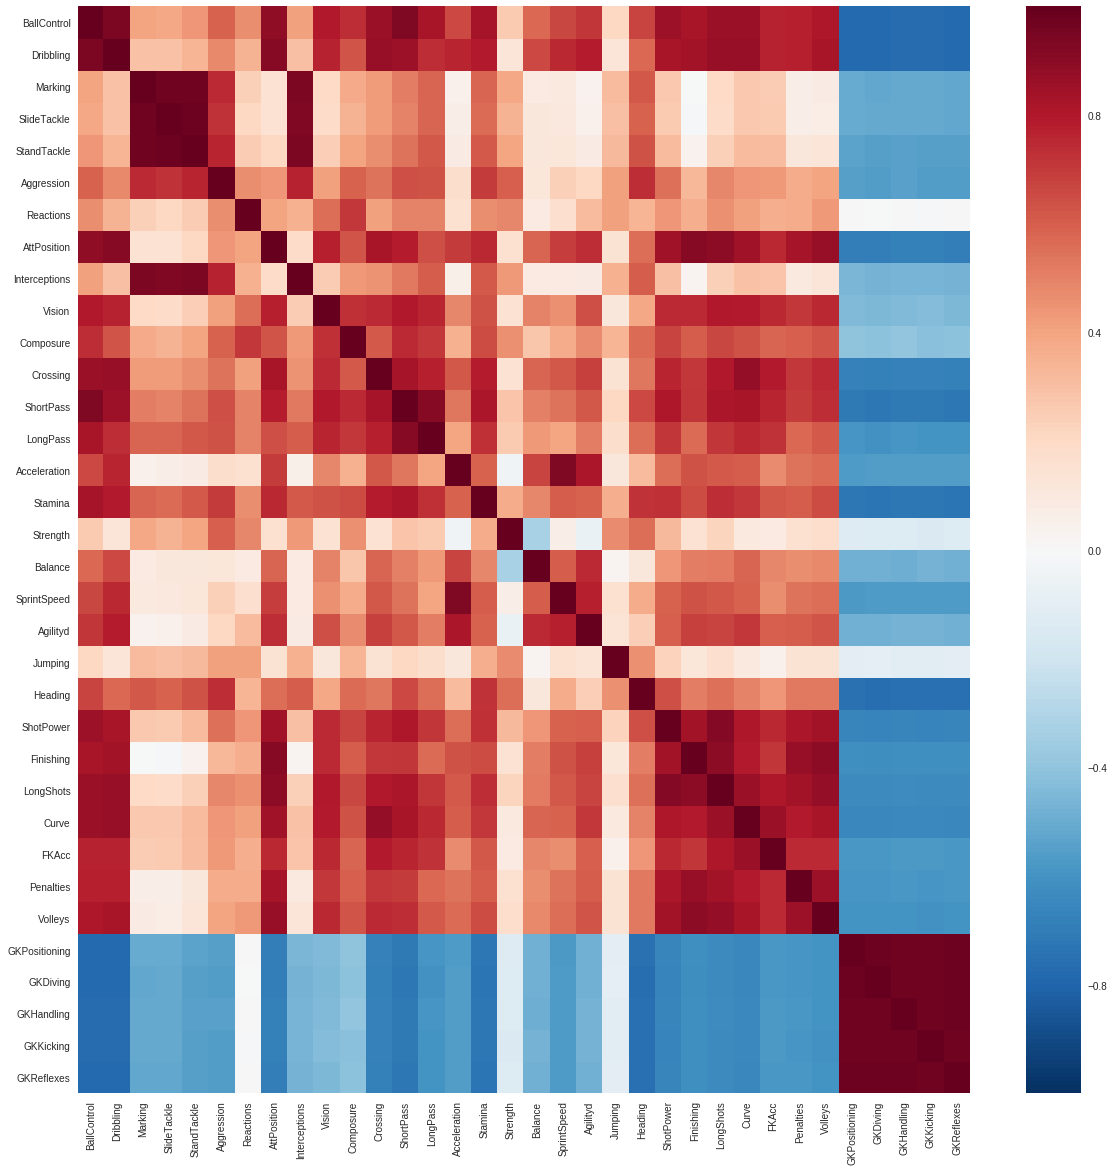

In [11]:
plt.figure(figsize=(20,20))
corr = csv[csv.columns[24:]] .corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show() #Display the correlation plot

In [11]:
stren = csv.Strength.tolist()
acce = csv.Acceleration.tolist()

plus = []

for ind in range(len(stren)):
    plus.append(stren[ind] + acce[ind])

sort_plus = sorted(plus)

top10p = sort_plus[-int(len(plus) * (1/10))]

resultOff = []

for item in plus:
    if (item >= top10p):
        resultOff.append(1)
    else:
        resultOff.append(0)

csv.insert(loc=58, column='GoodAtAttack', value=resultOff) #Add GoodAtAttack in contract to the csv

In [12]:
fini = csv.Finishing.tolist()
inter = csv.Interceptions.tolist()

plus = []

for ind in range(len(fini)):
    plus.append(fini[ind] + inter[ind])

sort_plus = sorted(plus)

top10p = sort_plus[-int(len(plus) * (1/10))]

resultSens = []

for item in plus:
    if (item >= top10p):
        resultSens.append(1)
    else:
        resultSens.append(0)

csv.insert(loc=59, column='GoodBallSense', value=resultSens) #Add GoodBallSense in contract to the csv

In [14]:
numerics = csv._get_numeric_data()
numerics = numerics.drop('OverallScore', 1)
numerics.head(10)

,IsHomeGrown,PotentialScore,PotentialGrowth(%),Height,Weight,IsPhysicalAnomaly,Age,NumberOfPositisions,SwitchedTeams,Contract,...,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes,GoodAtAttack,GoodBallSense
0,0,89,0,183,76,0,28,2,0,2018,...,79,67,77,6,6,14,10,14,0,0
1,1,90,7,188,86,0,23,1,0,2022,...,66,82,70,14,8,10,11,11,0,0
2,0,90,6,171,68,1,24,3,0,2020,...,79,64,75,14,12,7,9,6,0,0
3,0,89,0,172,74,1,28,1,0,2020,...,72,80,85,11,13,15,6,14,1,0
4,0,84,0,194,84,1,28,2,0,2019,...,67,69,74,14,7,15,12,9,0,1
5,0,85,0,192,85,1,30,1,0,2019,...,52,63,46,8,10,9,5,6,0,0
6,0,86,0,175,74,0,29,2,0,2019,...,81,80,81,15,6,10,8,15,0,0
7,0,87,4,179,62,1,25,2,0,2020,...,72,72,71,11,15,9,13,6,0,0
8,0,87,4,185,82,0,24,1,0,2021,...,70,59,50,7,7,8,11,13,0,0
9,0,85,0,184,80,0,33,1,0,2020,...,60,23,11,78,83,85,87,85,0,0


In [15]:
#Normalize all numeric values using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized = numerics
normalized[:] = scaler.fit_transform(numerics.values)

for name in list(numerics.dtypes.index):
    csv[name] = normalized[name]

csv.head(10)

/home/yaqinh/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


,PlayerID,Name,UpdateDate,Country,IsHomeGrown,OverallScore,PotentialScore,PotentialGrowth(%),Height,Weight,...,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes,GoodAtAttack,GoodBallSense
0,Mesut Özil 10/15/1988,Mesut Özil,Dec_12_2016,Germany,0.0,89,0.864865,0.000000,0.500,0.431818,...,0.853659,0.658824,0.816092,0.058824,0.057471,0.144444,0.104651,0.146067,0.0,0.0
1,Harry Kane 07/28/1993,Harry Kane,Dec_12_2016,England,1.0,84,0.891892,0.152174,0.625,0.659091,...,0.695122,0.835294,0.735632,0.152941,0.080460,0.100000,0.116279,0.112360,0.0,0.0
2,Coutinho 06/12/1992,Coutinho,Dec_12_2016,Brazil,0.0,85,0.891892,0.130435,0.200,0.250000,...,0.853659,0.623529,0.793103,0.152941,0.126437,0.066667,0.093023,0.056180,0.0,0.0
3,Sergio Agüero 06/02/1988,Sergio Agüero,Dec_12_2016,Argentina,0.0,89,0.864865,0.000000,0.225,0.386364,...,0.768293,0.811765,0.908046,0.117647,0.137931,0.155556,0.058140,0.146067,1.0,0.0
4,Nemanja Matić 08/01/1988,Nemanja Matić,Dec_12_2016,Serbia,0.0,84,0.729730,0.000000,0.775,0.613636,...,0.707317,0.682353,0.781609,0.152941,0.068966,0.155556,0.127907,0.089888,0.0,1.0
5,Vincent Kompany 04/10/1986,Vincent Kompany,Dec_12_2016,Belgium,0.0,85,0.756757,0.000000,0.725,0.636364,...,0.524390,0.611765,0.459770,0.082353,0.103448,0.088889,0.046512,0.056180,0.0,0.0
6,Cesc Fàbregas 05/04/1987,Cesc Fàbregas,Dec_12_2016,Spain,0.0,86,0.783784,0.000000,0.300,0.386364,...,0.878049,0.811765,0.862069,0.164706,0.057471,0.100000,0.081395,0.157303,0.0,0.0
7,Riyad Mahrez 02/21/1991,Riyad Mahrez,Dec_12_2016,Algeria,0.0,84,0.810811,0.086957,0.400,0.113636,...,0.768293,0.717647,0.747126,0.117647,0.160920,0.088889,0.139535,0.056180,0.0,0.0
8,Granit Xhaka 09/27/1992,Granit Xhaka,Dec_12_2016,Switzerland,0.0,84,0.810811,0.086957,0.550,0.568182,...,0.743902,0.564706,0.505747,0.070588,0.068966,0.077778,0.116279,0.134831,0.0,0.0
9,Claudio Bravo 04/13/1983,Claudio Bravo,Dec_12_2016,Chile,0.0,85,0.756757,0.000000,0.525,0.522727,...,0.621951,0.141176,0.057471,0.905882,0.942529,0.933333,1.000000,0.943820,0.0,0.0


In [16]:
#Transfer categorical values into numeric values
#df_1 = pd.get_dummies(csv['PlayerID'], prefix = 'PlayerID')
#df_2 = pd.get_dummies(csv['UpdateDate'], prefix = 'UpdateDate') 
df_3 = pd.get_dummies(csv['Country'], prefix = 'Country')
df_4 = pd.get_dummies(csv['PreferredFoot'], prefix = 'PreferredFoot')
df_5 = pd.get_dummies(csv['BirthDate'], prefix = 'BirthDate')
df_6 = pd.get_dummies(csv['AttWorkRate'], prefix = 'AttWorkRate')
df_7 = pd.get_dummies(csv['DefWorkRate'], prefix = 'DefWorkRate')
df_8 = pd.get_dummies(csv['PreferredPositions'], prefix = 'PreferredPositions')
df_9 = pd.get_dummies(csv['Team'], prefix = 'Team')
df_10 = pd.get_dummies(csv['TeamPosition'], prefix = 'TeamPosition')
df_11 = pd.get_dummies(csv['Year'], prefix = 'StartYear')
df_12 = pd.get_dummies(csv['Contract'], prefix = 'Contract')

csv_new = pd.concat([csv, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, df_11, df_12], axis=1)
csv_new = csv_new.drop( ['Name', 'Country', 'PreferredFoot', 'BirthDate', 
                         'AttWorkRate', 'DefWorkRate', 'PreferredPositions', 'Team', 
                         'TeamPosition', 'Year', 'Contract'], axis = 1)

In [18]:
csv.to_csv('FIFIndex_BPL_players_featured.csv', index=True, header=list(csv.dtypes.index), mode='w')

In [17]:
csv_new.to_csv('FIFIndex_BPL_players_numeric_featured.csv', index=True, header=list(csv_new.dtypes.index), mode='w')

In [131]:
#Take average numeric values for each player
playerIDs = set(csv.PlayerID.tolist())
avgList = []

for item in playerIDs:
    playercsv = csv[csv.PlayerID == item]
    new_playercsv = playercsv.drop(playercsv._get_numeric_data().dtypes.index.tolist(), axis = 1)
    cate = new_playercsv.head(1).reset_index()
    mean = pd.DataFrame(playercsv._get_numeric_data().mean())
    mean = mean.transpose()
    player_avg = pd.concat([cate, mean], axis=1)
    avgList.append(player_avg)

csv_avg = pd.concat(avgList, axis=0).reset_index().drop(['level_0', 'index'], axis = 1)
csv_avg.head(10)

,PlayerID,Name,UpdateDate,Country,PreferredFoot,BirthDate,AttWorkRate,DefWorkRate,PreferredPositions,Team,...,FKAcc,Penalties,Volleys,GKPositioning,GKDiving,GKHandling,GKKicking,GKReflexes,GoodAtAttack,GoodBallSense
0,Tom Lawrence 01/13/1994,Tom Lawrence,Aug_25_2016,Wales,Right,01/13/1994,Medium,Medium,LM/ST,Leicester City,...,0.731707,0.635294,0.425287,0.141176,0.103448,0.066667,0.139535,0.067416,0.000000,0.0
1,Marcos Alonso 12/28/1990,Marcos Alonso,Dec_12_2016,Spain,Left,12/28/1990,High,High,LW/LM/LB/LWB,Chelsea,...,0.756098,0.623529,0.505747,0.094118,0.091954,0.066667,0.139535,0.123596,0.000000,0.0
2,Luke Dreher 11/27/1998,Luke Dreher,Dec_12_2016,England,Right,11/27/1998,Medium,Medium,CM,Crystal Palace,...,0.451220,0.423529,0.310345,0.047059,0.080460,0.100000,0.116279,0.044944,0.000000,0.0
3,Georginio Wijnaldum 11/11/1990,Georginio Wijnaldum,Dec_12_2016,Netherlands,Right,11/11/1990,Medium,High,LM/CAM/CM,Liverpool,...,0.754947,0.741176,0.770115,0.129412,0.172414,0.055556,0.151163,0.056180,0.000000,1.0
4,Danny Barbir 01/31/1998,Danny Barbir,March_20_2017,United States,Right,01/31/1998,Medium,Medium,CB,West Brom,...,0.231707,0.388235,0.310345,0.105882,0.137931,0.066667,0.081395,0.101124,0.000000,0.0
5,Freddy Yao 02/17/1998,Freddy Yao,Dec_12_2016,Ivory Coast,Right,02/17/1998,Medium,Medium,CM,Burnley,...,0.353659,0.400000,0.402299,0.152941,0.114943,0.144444,0.116279,0.146067,0.000000,0.0
6,Fernando 07/25/1987,Fernando,Dec_12_2016,Brazil,Right,07/25/1987,Medium,High,CDM/CM,Manchester City,...,0.536585,0.505882,0.402299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
7,Callum McManaman 04/25/1991,Callum McManaman,Dec_12_2016,England,Right,04/25/1991,High,Medium,ST/RW/RM,West Brom,...,0.329268,0.623529,0.563218,0.152941,0.103448,0.133333,0.162791,0.101124,0.000000,0.0
8,Pape Souaré 06/06/1990,Pape Souaré,Dec_12_2016,Senegal,Left,06/06/1990,High,Medium,LB,Crystal Palace,...,0.732628,0.447059,0.425287,0.176471,0.080460,0.077778,0.151163,0.101124,0.188679,0.0
9,Vashon Neufville 07/18/1999,Vashon Neufville,Nov_10_2016,England,Left,07/18/1999,High,Medium,LB,West Ham,...,0.158537,0.258824,0.160920,0.164706,0.068966,0.122222,0.093023,0.056180,0.000000,0.0


In [132]:
csv_avg.to_csv('FIFIndex_BPL_players_featured_averaged.csv', index=True, header=list(csv_avg.dtypes.index), mode='w')